基于scikit-learn通过Ward方法进行聚类， Ward方法是分层聚类方法之一

###  导入包

In [1]:
import csv
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
print(rdBase.rdkitVersion)

2021.03.5


In [2]:
# 载入数据
csv_file = "C:/Users/KerryChen/Desktop/Anni-clustering.csv"
csv_reader = csv.reader(open(csv_file))
next(csv_reader)
data = []
for line in csv_reader:
    sml = line[2]
    mol = Chem.MolFromSmiles(sml)

    if mol:
        data.append(mol)
n = len(data)

np.random.seed(1234)
np.random.shuffle(data)

In [3]:
#　Morgan指纹生成和距离矩阵计算
#　创建指纹作为聚类的输入数据，并使用它创建距离矩阵。
#　通过设置returnDistance = True选项，BulkTanimotoSimilarity的输出将更改为由“ 1 – Tanimoto系数”计算的距离，然后使用它来创建距离矩阵。
morgan_fp = [AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in data]
dis_matrix = [DataStructs.BulkTanimotoSimilarity(morgan_fp[i], morgan_fp[:n], returnDistance=True) for i in range(n)]
dis_array = np.array(dis_matrix)

In [4]:
# 使用Ward方法将其分为6个类，右边那一列表示每一个簇有多少个分子
ward = AgglomerativeClustering(n_clusters=6)
ward.fit(dis_array)
pd.value_counts(ward.labels_)

C:\Users\KerryChen\AppData\Roaming\Python\Python36\site-packages\scipy\cluster\hierarchy.py:826: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


0    86
2    69
1    68
5     6
4     5
3     4
dtype: int64

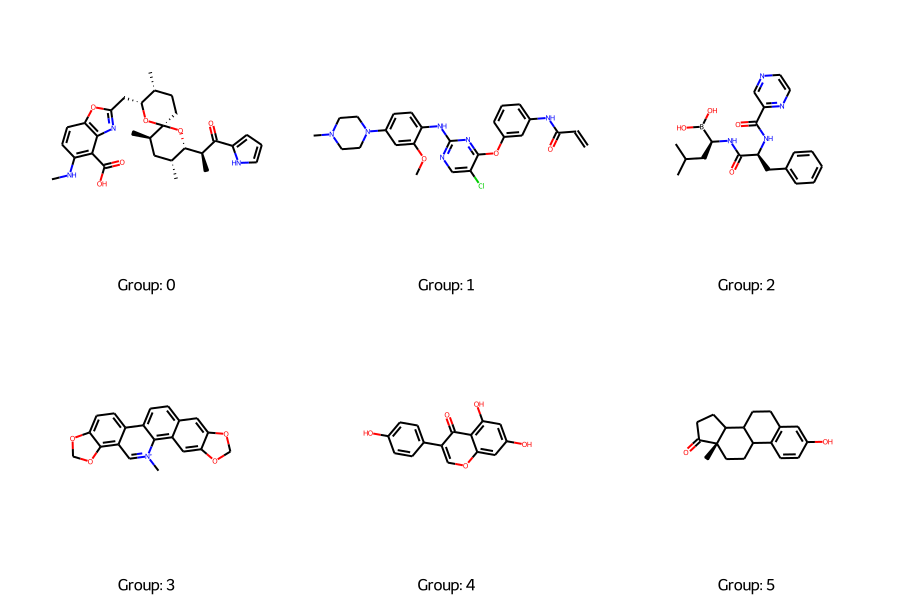

In [5]:
# 通过从每个簇中随机抽取分子来比较结构。将簇名称和分子与字典类型匹配之后随机选择一个分子。
ward_library = {i: [] for i in range(6)}
for n,j in enumerate(ward.labels_):
    ward_library[j].append(data[n])
selected_compounds = [np.random.choice(ward_library[i]) for i in range(6)]

img = Draw.MolsToGridImage(selected_compounds, 
                           molsPerRow=3,subImgSize=(300, 300), 
                           legends=["Group"+ ': ' + str(i) for i in range(6)],
                          returnPNG=False)
img.save('WardCluster.png')

# 显示在下方
Draw.MolsToGridImage(selected_compounds, 
                           molsPerRow=3,subImgSize=(300, 300), 
                           legends=["Group"+ ': ' + str(i) for i in range(6)])

(0.0, 2380.0)


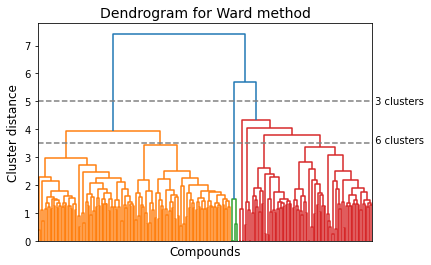

In [6]:
# 通过树状图可视化聚类结果
from scipy.cluster import hierarchy
linked_array = hierarchy.ward(dis_array)
hierarchy.dendrogram(linked_array)
ax = plt.gca()
bounds = ax.get_xbound()
print(bounds)
ax.plot(bounds, [3.5,3.5], '--', c='gray')
ax.plot(bounds, [5,5], '--', c='gray')
ax.text(bounds[1], 5, ' 3 clusters', va='center')
ax.text(bounds[1], 3.5, ' 6 clusters')
plt.xlabel('Compounds', fontsize=12)
plt.xticks([])
plt.ylabel('Cluster distance', fontsize=12)
plt.title('Dendrogram for Ward method', fontsize=14)
plt.savefig("bar.png")
plt.show()

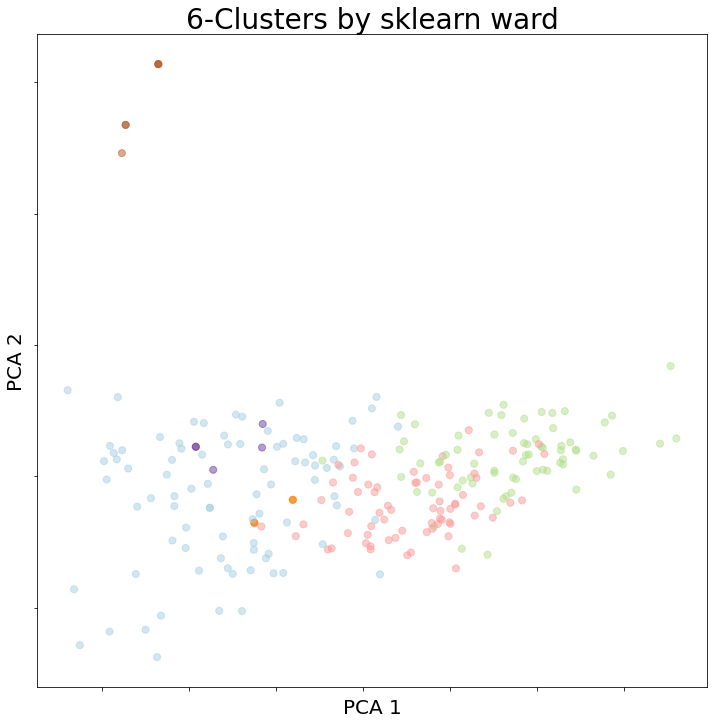

In [7]:
# PCA:主成分分析
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dis_array)
dis_pca = pca.transform(dis_array)
n = len(data)
#可视化
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.scatter(dis_pca[:,0], dis_pca[:,1], s=50, c=ward.labels_[:n], cmap='Paired', alpha=0.5)
ax.set_xlabel('PCA 1', fontsize=20)
ax.set_xticklabels([])
ax.set_ylabel('PCA 2', fontsize=20)
ax.set_yticklabels([])
ax.set_title('6-Clusters by sklearn ward', fontsize=28)
plt.savefig("cluster.png")
plt.show()

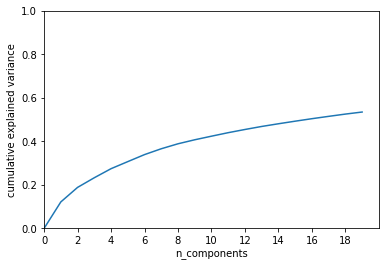

In [8]:
# 主成分分析中的累积贡献
pca_all = PCA()
pca_all.fit(dis_array)
ev_ratio = np.hstack([0, np.cumsum(pca_all.explained_variance_ratio_)])
plt.plot(ev_ratio[:20])
plt.xlim([0,20])
plt.xticks(range(0,20,2))
plt.ylim([0,1.0])
plt.xlabel('n_components')
plt.ylabel('cumulative explained variance')
plt.savefig("pca.png")
plt.show()